# Statistical analysisa and examples

In [131]:
import sys
sys.path.append('../common')
from utils import weight3 as weight_fn, weight_by_index
from utils import bag_weight, score, mean_n_sigma, score_stats
from utils import MAX_WEIGHT, AVAILABLE_GIFTS, GIFT_TYPES, N_TYPES, N_BAGS

from copy import deepcopy
from collections import defaultdict

import numpy as np
np.random.seed(2017)
import matplotlib.pyplot as plt
%matplotlib inline

Find optimal number of a single gift in the bag for a given rejection probability.

21
(957, 0.095699999999999993)
(21, 36.854131188127248, 368541.31188127247, 0.095699999999999993)
(22, 34.4924374896407, 344924.37489640701, 0.17630000000000001)
(20, 37.632215886726534, 376322.15886726533, 0.043700000000000003)
(19, 37.073197013856543, 370731.97013856546, 0.016500000000000001)


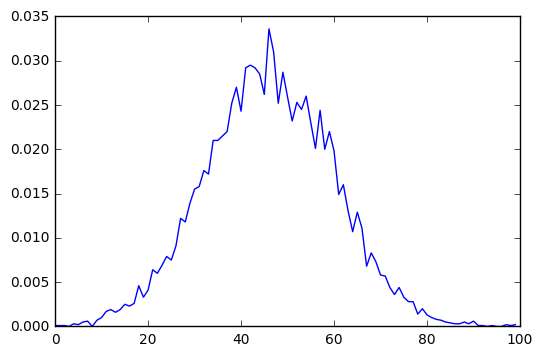

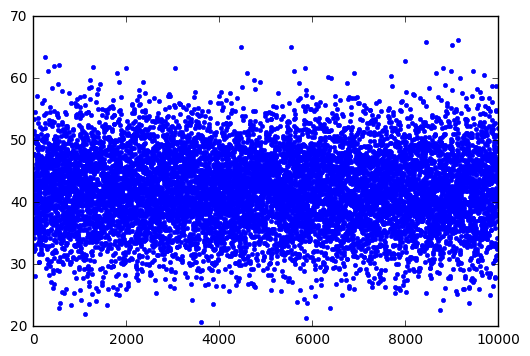

In [132]:
index = 0
weights = np.array([weight_by_index(index) for i in range(10000)])
hist = np.histogram(weights, bins=2*MAX_WEIGHT)

pdf = hist[0] *1.0 / np.sum(hist[0])
x = hist[1][:-1]

plt.figure()
plt.plot(pdf)

def find_n(pdf, x, epsilon=0.1):
    for n in range(1, 1000):
        y = MAX_WEIGHT * 1.0 / n
        res = np.where(x > y)[0]
        if len(res) > 0:
            index = res[0]
            pr = np.sum(pdf[index:])
            if pr > epsilon:
                return n-1
            
n = find_n(pdf, x, epsilon=0.1)
print(n)

print(np.sum(weights * n > MAX_WEIGHT), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

plt.figure()
plt.plot(weights * n, '.')


nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n += 1
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n -= 2
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n -= 1
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

Single gift optimization

In [133]:
N_TRIALS = 10000
GIFT_WEIGHTS = np.zeros((N_TRIALS, N_TYPES))
for index in range(N_TYPES):
    GIFT_WEIGHTS[:, index] = [weight_by_index(index) for i in range(10000)]

In [134]:
def find_n(weights):
    best_mean_score = 0
    best_n = 0
    for n in range(1, 500):
        mask = weights * n < MAX_WEIGHT
        if not mask.any():
            break
        score = np.sum(weights[mask] * n) * 1.0 / len(weights)  
        if score > best_mean_score:
            best_mean_score = score
            best_n = n
            
    return best_n, best_mean_score

LIMIT_NB_GIFTS = np.zeros((N_TYPES), dtype=np.uint8)

for index in range(N_TYPES):
    n, s = find_n(GIFT_WEIGHTS[:,index])
    print GIFT_TYPES[index], index, n, s
    LIMIT_NB_GIFTS[index] = n + 1


# print(np.sum(weights * n > MAX_WEIGHT), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n += 1
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n -= 2
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n -= 1
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

ball 0 20 37.4234804812
bike 1 2 20.894396983
blocks 2 3 31.035015986
book 3 14 14.8081476464
coal 4 1 23.3168017351
doll 5 6 25.1941147626
gloves 6 50 17.4548048468
horse 7 6 27.5209411252
train 8 3 24.8407205528


In [135]:
LIMIT_NB_GIFTS, np.prod(LIMIT_NB_GIFTS)

(array([21,  3,  4, 15,  2,  7, 51,  7,  4], dtype=uint8), 75569760)

## Multi-gift optimization

In [14]:
n_trials = 10000
weights = np.zeros((n_trials, N_TYPES))
for index in range(N_TYPES):
    weights[:, index] = [weight_by_index(index) for i in range(10000)]

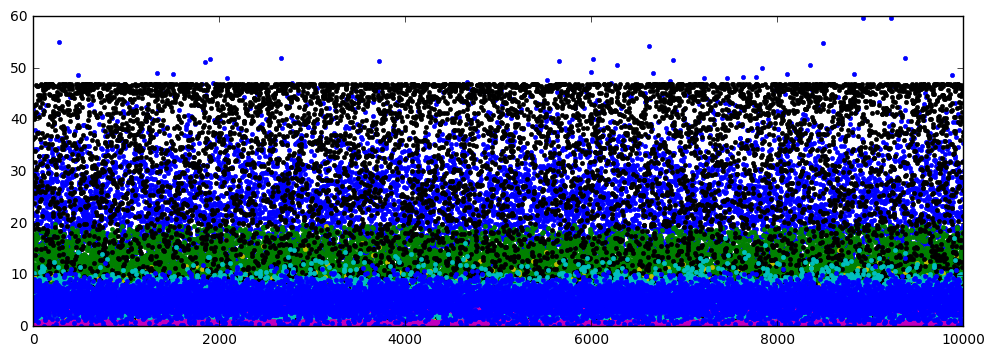

In [15]:
plt.figure(figsize=(12,4))    
colors = ['r','b','g','y','k','c','m','']
for index in range(N_TYPES-1):    
    plt.plot(weights[:, index], '.'+colors[index])

In [136]:
def compute_score(state):
    s = np.sum(GIFT_WEIGHTS * state, axis=1)
    mask = s < MAX_WEIGHT
    rejected = (N_TRIALS - np.sum(mask))*1.0 / N_TRIALS
    score = np.sum(s[mask]) * 1.0 / N_TRIALS
    return score, rejected


state = np.zeros((N_TYPES), dtype=np.uint8)
state[1] = 1
compute_score(state)

(20.129035166877681, 0.001)

In [137]:
alpha = 0.745
goal_weight = MAX_WEIGHT * alpha
print goal_weight

37.25


In [138]:
# available_gifts['ball'] = 0
available_gifts

{'ball': 0,
 'bike': 497,
 'blocks': 0,
 'book': 320,
 'coal': 0,
 'doll': 0,
 'gloves': 0,
 'horse': 0,
 'train': 629}

In [139]:
LIMIT_NB_GIFTS

array([21,  3,  4, 15,  2,  7, 51,  7,  4], dtype=uint8)

In [71]:
def huge_loop2(rejected_threshold):
    scores = []
    for n0 in range(LIMIT_NB_GIFTS[0]):
        print "n0: ", n0, "/", LIMIT_NB_GIFTS[0]
        state = np.array([n0, 0, 0, 0, 0, 0, 0, 0, 0])
        s, r = compute_score(state)
        if r > rejected_threshold:
            break
        for n1 in range(LIMIT_NB_GIFTS[1]):
            state = np.array([n0, n1, 0, 0, 0, 0, 0, 0, 0])
            s, r = compute_score(state)
            if r > rejected_threshold:
                break
            for n2 in range(LIMIT_NB_GIFTS[2]):
                state = np.array([n0, n1, n2, 0, 0, 0, 0, 0, 0])
                s, r = compute_score(state)
                if r > rejected_threshold:
                    break
                for n3 in range(LIMIT_NB_GIFTS[3]):
                    state = np.array([n0, n1, n2, n3, 0, 0, 0, 0, 0])
                    s, r = compute_score(state)
                    if r > rejected_threshold:
                        break
                    for n4 in range(LIMIT_NB_GIFTS[4]):
                        state = np.array([n0, n1, n2, n3, n4, 0, 0, 0, 0])
                        s, r = compute_score(state)
                        if r > rejected_threshold:
                            break                        
                        for n5 in range(LIMIT_NB_GIFTS[5]):
                            state = np.array([n0, n1, n2, n3, n4, n5, 0, 0, 0])
                            s, r = compute_score(state)
                            if r > rejected_threshold:
                                break                        
                            for n6 in range(LIMIT_NB_GIFTS[6]):
                                state = np.array([n0, n1, n2, n3, n4, n5, n6, 0, 0])
                                s, r = compute_score(state)
                                if r > rejected_threshold:
                                    break                        
                                for n7 in range(LIMIT_NB_GIFTS[7]):
                                    state = np.array([n0, n1, n2, n3, n4, n5, n6, n7, 0])
                                    s, r = compute_score(state)
                                    if r > rejected_threshold:
                                        break                        
                                    for n8 in range(LIMIT_NB_GIFTS[8]):
                                        state = np.array([n0, n1, n2, n3, n4, n5, n6, n7, n8])
                                        s, r = compute_score(state)
                                        if r > rejected_threshold:
                                            break                                    
                                        scores.append((state, s, r))
    return scores

In [168]:
scores = huge_loop2(0.75)

n0:  0 / 21
n0:  1 / 21
n0:  2 / 21
n0:  3 / 21
n0:  4 / 21
n0:  5 / 21
n0:  6 / 21
n0:  7 / 21
n0:  8 / 21
n0:  9 / 21
n0:  10 / 21
n0:  11 / 21
n0:  12 / 21
n0:  13 / 21
n0:  14 / 21
n0:  15 / 21
n0:  16 / 21
n0:  17 / 21
n0:  18 / 21
n0:  19 / 21
n0:  20 / 21


In [169]:
scores = np.array(scores)

In [170]:
alpha = 0.745
goal_weight = MAX_WEIGHT * alpha
print goal_weight

mask = scores[:, 1] > goal_weight
len(scores[mask]), scores[mask][:10, :]

37.25


(95, array([[array([6, 0, 1, 0, 0, 1, 1, 2, 0]), 37.369679272344804,
         0.053100000000000001],
        [array([7, 0, 1, 0, 0, 1, 0, 2, 0]), 37.527485719297054, 0.0613],
        [array([7, 0, 1, 1, 0, 1, 1, 1, 0]), 37.692940257865537, 0.0275],
        [array([7, 0, 1, 1, 0, 1, 2, 1, 0]), 37.344681205583392,
         0.060299999999999999],
        [array([8, 0, 1, 0, 0, 0, 1, 2, 0]), 37.552428587718268,
         0.030200000000000001],
        [array([8, 0, 1, 0, 0, 1, 1, 1, 0]), 38.087460032735109,
         0.020199999999999999],
        [array([8, 0, 1, 0, 0, 1, 2, 1, 0]), 37.604165717166701,
         0.055899999999999998],
        [array([8, 0, 1, 1, 0, 0, 0, 2, 0]), 37.423255074748297,
         0.043799999999999999],
        [array([8, 0, 1, 1, 0, 1, 0, 1, 0]), 37.992242875631888, 0.0332],
        [array([8, 0, 1, 1, 0, 1, 1, 1, 0]), 37.998889924227164,
         0.059499999999999997]], dtype=object))

In [171]:
# Save result
np.save("scores_r_075.npy", scores)

In [347]:
def has_min_nb_gifts(state):
    return np.sum(state) >= 3 

def is_available(state, available_gifts, gift_types=GIFT_TYPES):
    for v, gift_type in zip(state, gift_types):
        if available_gifts[gift_type] - v < 0:
            return False
    return True

def update_available_gifts(available_gifts, state, gift_types=GIFT_TYPES):
    for v, gift_type in zip(state, gift_types):
        assert available_gifts[gift_type] - v >= 0, "Found state is not available : {}, {}".format(state, available_gifts)
        available_gifts[gift_type] = available_gifts[gift_type] - v

def fill_bags(sorted_scores, available_gifts):
    
    filled_bags = np.zeros((N_BAGS, N_TYPES), dtype=np.uint8)
    
    last_score_computation = -1
    good_bag_index = 0
    bag_index = 0
    while bag_index < N_BAGS and good_bag_index < len(sorted_scores):
    
        state = sorted_scores[good_bag_index, 0]
        if is_available(state, available_gifts) and has_min_nb_gifts(state):
            # print "bag index : ", bag_index
            update_available_gifts(available_gifts, state, GIFT_TYPES)
            filled_bags[bag_index, :] = state
            bag_index += 1
        else:
            good_bag_index += 1
                
        if bag_index > 0 and (bag_index % 100) == 0 and last_score_computation < bag_index:
            s, r = score(filled_bags, return_rejected=True)
            print(bag_index, ">>> Current score: ", s, s * N_BAGS *1.0 / bag_index, "rejected=", r)
            last_score_computation = bag_index

        if bag_index > 0 and (bag_index % 150) == 0 and last_score_computation < bag_index:
            print(bag_index, ">>> Currently available gifts : ", [(k, available_gifts[k]) for k in GIFT_TYPES])
            last_score_computation = bag_index
    
    return filled_bags



def fill_bags2(sorted_scores, available_gifts, n_gloves=70):
    
    filled_bags = np.zeros((N_BAGS, N_TYPES), dtype=np.uint8)
    
    last_score_computation = -1
    good_bag_index = 0
    bag_index = 0
    
    n_coals = int(n_gloves * 0.5)
    available_gifts['gloves'] = AVAILABLE_GIFTS['gloves'] - n_gloves
    
    while bag_index < N_BAGS-n_coals and good_bag_index < len(sorted_scores):
    
        state = sorted_scores[good_bag_index, 0]
        if is_available(state, available_gifts) and has_min_nb_gifts(state):
            # print "bag index : ", bag_index
            update_available_gifts(available_gifts, state, GIFT_TYPES)
            filled_bags[bag_index, :] = state
            bag_index += 1
        else:
            good_bag_index += 1
                
        if bag_index > 0 and (bag_index % 100) == 0 and last_score_computation < bag_index:
            s, r = score(filled_bags, return_rejected=True)
            print(bag_index, ">>> Current score: ", s, s * N_BAGS *1.0 / bag_index, "rejected=", r)
            last_score_computation = bag_index

        if bag_index > 0 and (bag_index % 150) == 0 and last_score_computation < bag_index:
            print(bag_index, ">>> Currently available gifts : ", [(k, available_gifts[k]) for k in GIFT_TYPES])
            last_score_computation = bag_index
    
    available_gifts['gloves'] = n_gloves
    while bag_index < N_BAGS and good_bag_index < len(sorted_scores):
        state = np.array([0,0,0,0,1,0,2,0,0])
        if is_available(state, available_gifts) and has_min_nb_gifts(state):
            # print "bag index : ", bag_index
            update_available_gifts(available_gifts, state, GIFT_TYPES)
            filled_bags[bag_index, :] = state
            bag_index += 1
        else:
            good_bag_index += 1
                
        if bag_index > 0 and (bag_index % 100) == 0 and last_score_computation < bag_index:
            s, r = score(filled_bags, return_rejected=True)
            print(bag_index, ">>> Current score: ", s, s * N_BAGS *1.0 / bag_index, "rejected=", r)
            last_score_computation = bag_index

        if bag_index > 0 and (bag_index % 150) == 0 and last_score_computation < bag_index:
            print(bag_index, ">>> Currently available gifts : ", [(k, available_gifts[k]) for k in GIFT_TYPES])
            last_score_computation = bag_index
        
    
    return filled_bags

In [337]:
sorted_scores = scores[scores[:,1].argsort()][::-1]
# sorted_scores = scores[scores[:,2].argsort()]

In [357]:
# # for r in [100, 0.5, 0.1, 0.075]:
# for r in [0.75,]:
#     print "\n\n--- Start bags filling with : r=", r
#     mask = sorted_scores[:, 2] < r
#     sorted_scores = sorted_scores[mask]
#     print "\n---", len(sorted_scores), sorted_scores[:5, :]
#     available_gifts = deepcopy(AVAILABLE_GIFTS)
#     print "\n--------------\n"
#     filled_bags = fill_bags(sorted_scores, available_gifts)

r = 100.0
print "\n\n--- Start bags filling with : r=", r
mask = sorted_scores[:, 2] < r
sorted_scores = sorted_scores[mask]
print "\n---", len(sorted_scores), sorted_scores[:5, :]
available_gifts = deepcopy(AVAILABLE_GIFTS)
print "\n--------------\n"
n_gloves = 68
filled_bags = fill_bags2(sorted_scores, available_gifts, n_gloves=n_gloves)
s, r = score(filled_bags, return_rejected=True)



--- Start bags filling with : r= 100.0

--- 499104 [[array([12,  0,  1,  0,  0,  0,  0,  1,  0]) 38.704855041006837
  0.038300000000000001]
 [array([12,  0,  1,  0,  0,  1,  0,  0,  0]) 38.47525620909795
  0.042599999999999999]
 [array([11,  0,  1,  0,  0,  0,  1,  1,  0]) 38.463477823310129
  0.031600000000000003]
 [array([9, 0, 1, 0, 0, 1, 0, 1, 0]) 38.41559619952325 0.0253]
 [array([9, 0, 1, 0, 0, 1, 1, 1, 0]) 38.408758012451742 0.0521]]

--------------

(100, '>>> Current score: ', 3988.5680719391316, 39885.680719391319, 'rejected=', 1.21)
(150, '>>> Currently available gifts : ', [('ball', 0), ('bike', 500), ('blocks', 850), ('book', 1200), ('coal', 166), ('doll', 941), ('gloves', 73), ('horse', 792), ('train', 942)])
(200, '>>> Current score: ', 7576.000954991835, 37880.004774959176, 'rejected=', 5.5700000000000003)
(300, '>>> Current score: ', 11064.994544587611, 36883.31514862537, 'rejected=', 12.119999999999999)
(400, '>>> Current score: ', 14635.510147592409, 36588.77536898

In [175]:
# available_gifts = deepcopy(AVAILABLE_GIFTS)
# filled_bags = fill_bags(sorted_scores, available_gifts)

In [339]:
print score(filled_bags, return_rejected=True), available_gifts

(818.24493600602671, 1.76) {'horse': 1000, 'ball': 1100, 'blocks': 1000, 'doll': 1000, 'train': 1000, 'coal': 131, 'bike': 500, 'gloves': 0, 'book': 1200}


In [358]:
for state in filled_bags[-100:, :]:
    print bag_weight(state, n1=1)

32.8335416865
27.2616976715
29.3291120095
44.8357592611
43.4246388943
25.8140468823
46.4493636559
32.4759674445
41.7741320927
40.9563178574
53.3394664334
24.9963887741
52.7982338812
29.0654634364
25.124814998
36.5034187059
37.6911431211
32.2784276431
55.4545900617
38.4473493861
21.2573506055
25.0999852428
16.6656527081
47.1856730435
32.0058465153
41.0726415676
39.4988064835
38.1991256381
36.4660067849
42.2477798035
41.4794556344
57.1285698179
29.859148658
23.0348135953
20.5934331541
51.4449031141
42.5160756019
19.5576992193
40.0315513057
47.4505528544
55.9538368168
41.8832980483
37.3023033119
31.6598830367
12.4592902298
23.7557901677
29.8692817353
21.8232190747
44.4587790896
33.8812799802
32.9254307291
26.5190526832
40.4657706671
32.6797720243
24.1268342112
38.9816406855
37.9053080878
58.763938234
22.2686247608
62.5145227079
52.0615803981
36.4478735623
40.1216128776
47.9621132191
26.3853162853
45.6748025828
11.0227381102
38.4571893171
27.9558124843
1.44036359904
6.57029270915
10.349612

(23.088245759383238, 0.057700000000000001) (23.087111470586706, 0.059999999999999998)


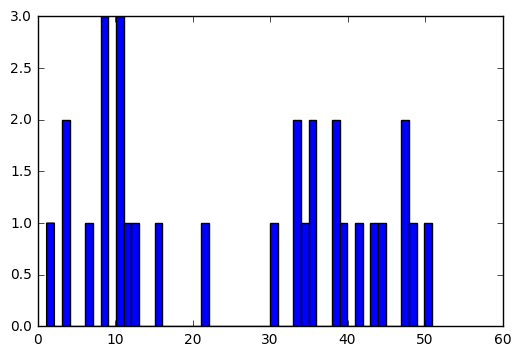

In [351]:
gloves_coal_state = np.array([0,0,0,0,1,0,2,0,0])
print compute_score(gloves_coal_state), score((gloves_coal_state,), return_rejected=True)
weights = np.array([bag_weight(gloves_coal_state, n1=1) for i in range(30)])
_ = plt.hist(weights, bins=MAX_WEIGHT)



In [328]:
def to_submission(state, available_gifts, gift_types):
    n_gifts = [available_gifts[t] for t in gift_types]
    output = []
    for bag in state:
        o = []
        for index, count in enumerate(bag):   
            gift_type = gift_types[index]
            for i in range(count):
                v = n_gifts[index] - 1
                assert v >= 0, "Gift index is negative"
                o.append(gift_type + '_%i' % v)
                n_gifts[index] -= 1
        output.append(o)  
    return output

def write_submission(state, filename):
    with open(filename, 'w') as w:
        w.write("Gifts\n")
        for bag in state:
            w.write(' '.join(bag) + '\n')
    


In [329]:
from datetime import datetime
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'  
        
submission = to_submission(filled_bags, AVAILABLE_GIFTS, GIFT_TYPES)    
write_submission(submission, submission_file)        

### Some results 

- submission_2017-01-27-15-51.csv
- Local : 34722.394251084297
- Kaggle: 35143.27282


- submission_2017-01-27-16-00.csv
- Local : 31405.637035241478
- Kaggle : 31645.38768


- submission_2017-01-27-16-36.csv
- Local : 34083
- Kaggle : 34040.37733